# Cryptocurrency Price Forecasting

I will initially work with only the Bitcoin data and may in future generalise the code and use it for other cryptos if it works out for Bitcoin.

In [74]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from math import sqrt
from itertools import product
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 }, 
        palette=sns.xkcd_palette(colors))

In [75]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
all_currencies_df = pd.read_csv('../input/all_currencies.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
all_currencies_df = all_currencies_df.loc[:, ~all_currencies_df.columns.str.contains('^Unnamed')]
all_currencies_df.head()

,Symbol,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2015-11-12,$$$,0.000013,0.000017,0.000013,0.000017,142.0,NaN
2015-11-13,$$$,0.000017,0.000033,0.000016,0.000024,85.0,NaN
2015-11-14,$$$,0.000024,0.000053,0.000023,0.000030,131.0,NaN
2015-11-15,$$$,0.000030,0.000063,0.000022,0.000035,132.0,NaN
2015-11-16,$$$,0.000035,0.000046,0.000032,0.000036,280.0,NaN


In [76]:
# Split the data into train and test set 
# Lets leave just 1 month of test data as a month is a long time in the cryptocurrency space
train_df = all_currencies_df.loc[:'2018-02-28']
test_df = all_currencies_df.loc['2018-03-01':]
print("Original dataset: ", all_currencies_df.shape)
print("Train dataset: ", train_df.shape)
print("Test dataset: ", test_df.shape)

Original dataset:  (627839, 7)
Train dataset:  (600257, 7)
Test dataset:  (27582, 7)


In [77]:
# Extract the bitcoin data only
btc_df = all_currencies_df[all_currencies_df['Symbol'] == 'BTC']
btc_train_df=train_df[train_df['Symbol'] == 'BTC']
btc_test_df=test_df[test_df['Symbol'] == 'BTC']

In [78]:
# Plot BTC train and test

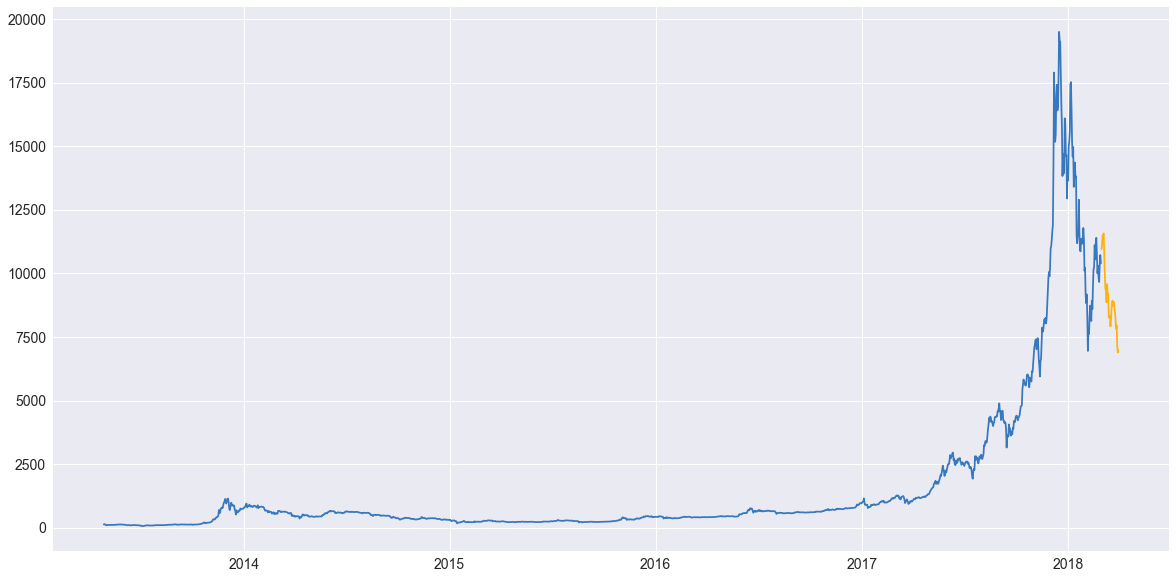

In [79]:
plt.plot(btc_train_df['Close'])
plt.plot(btc_test_df['Close'])

## Naive Forecast

The naive forecast, where the observation from the previous time step is used as the prediction for the observation at the next time step, will be used as a baseline for further prediction methods.

In [81]:
# Get a naive forecast
close_history = [x for x in btc_train_df['Close']]
predictions = list()
for i in range(len(btc_test_df)):
    # predict
    predictions.append(close_history[-1])
    # update observation
    close_history.append(btc_test_df.iloc[i]['Close'])
    
# Calculate RMSE
rmse = sqrt(mean_squared_error(btc_test_df['Close'], predictions))
print('RMSE: %.2f' % rmse)

RMSE: 418.86


Text(0.5,1,'Naive forecast')

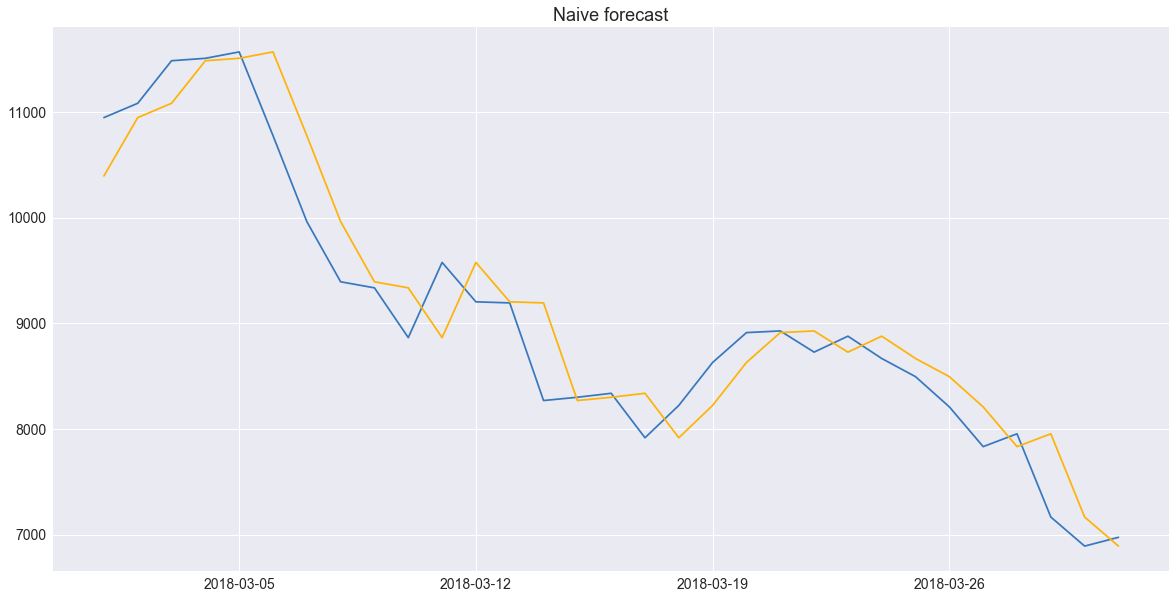

In [22]:
btc_test_df['yhat_naive'] = predictions

# Plot predictions vs actual
plt.plot(btc_test_df['Close'])
plt.plot(btc_test_df['yhat_naive'])
plt.title('Naive forecast')

## Moving Averages

Lets have a look at the Bitcoin timeseries and plot some moving averages. We'll take the most common 20, 50 and 200 moving averages and see how well they perform as a prediction of the BTC price for the next month.

In [23]:
# Get moving averages
btc_train_df['20ma'] = btc_train_df['Close'].rolling(20).mean()
btc_train_df['50ma'] = btc_train_df['Close'].rolling(50).mean()
btc_train_df['200ma'] = btc_train_df['Close'].rolling(200).mean()

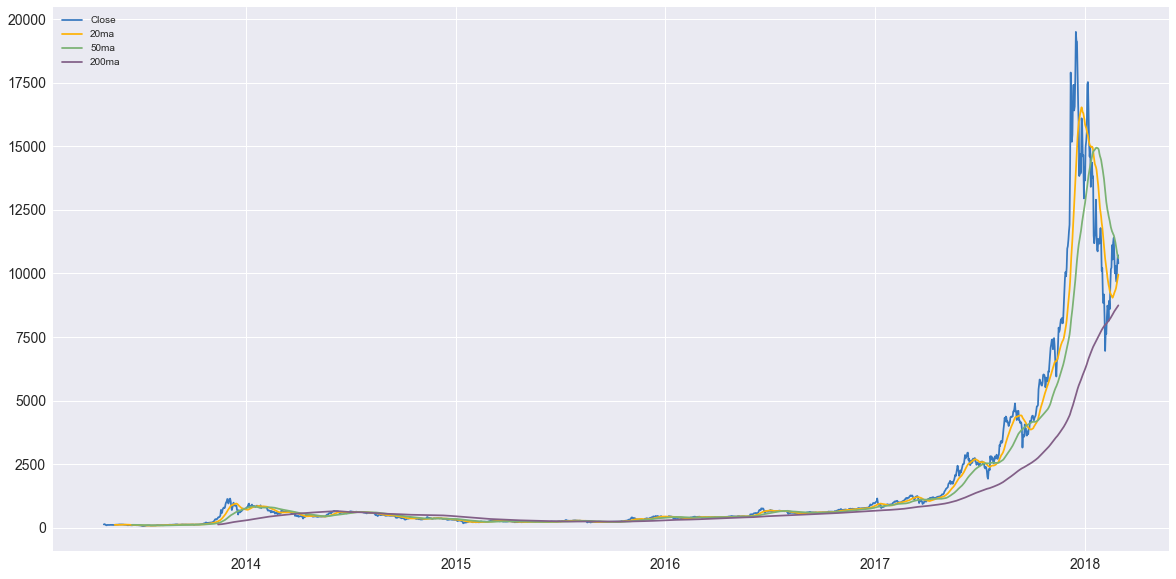

In [24]:
# Plot BTC Close and moving averages
plt.plot(btc_train_df['Close'])
plt.plot(btc_train_df['20ma'])
plt.plot(btc_train_df['50ma'])
plt.plot(btc_train_df['200ma'])
plt.legend(loc='upper left')

In [25]:
# Get a 20ma forecast
close_history = [x for x in btc_train_df['Close']]
predictions = list()
for i in range(len(btc_test_df)):
    # predict
    yhat = btc_train_df['Close'].rolling(20).mean().iloc[-1]
    predictions.append(yhat)
    # update observation
    close_history.append(btc_test_df.iloc[i]['Close'])
    
# Calculate RMSE
rmse = sqrt(mean_squared_error(btc_test_df['Close'], predictions))
print('RMSE: %.2f' % rmse)

RMSE: 1575.98


Not surprisingly, the 20-day moving average performs worse than the naive forecast. We won't even try to use the 50 and 200-day moving averages as predictors.

## Simple Exponential Smoothing

Note: Up until now we have been making predictions by looking at all actual values up until the day we want to predict for. However, in the real world we will not have this data if we are predicting prices for the next month. So lets keep it real and switch to a method of prediction where we predict all values for the next month based on only data from before that month. 

Lets quickly get the RMSE baseline and RMSE for moving average forecasting methods using this method.

In [37]:
# Calculate RMSE for Naive forecast, month
btc_test_df['naive_yhat'] = btc_test_df.iloc[len(btc_test_df)-1]['Close']
rmse = sqrt(mean_squared_error(btc_test_df.Close, btc_test_df.naive_yhat))
print('RMSE Naive: %.2f' % rmse)

RMSE: 2431.87


In [39]:
# Calculate RMSE for Moving average forecasts, month
btc_test_df['ma20_yhat'] = btc_train_df['Close'].rolling(20).mean().iloc[-1]
btc_test_df['ma50_yhat'] = btc_train_df['Close'].rolling(50).mean().iloc[-1]
btc_test_df['ma200_yhat'] = btc_train_df['Close'].rolling(200).mean().iloc[-1]

rmse = sqrt(mean_squared_error(btc_test_df.Close, btc_test_df.ma20_yhat))
print('RMSE 20-MA: %.2f' % rmse)
rmse = sqrt(mean_squared_error(btc_test_df.Close, btc_test_df.ma50_yhat))
print('RMSE 50-MA: %.2f' % rmse)
rmse = sqrt(mean_squared_error(btc_test_df.Close, btc_test_df.ma200_yhat))
print('RMSE 200-MA: %.2f' % rmse)

RMSE 20-MA: 1575.98
RMSE 50-MA: 2021.78
RMSE 200-MA: 1314.65


The 200-day moving average prediction method turns out to be the best we have so far when using this method.

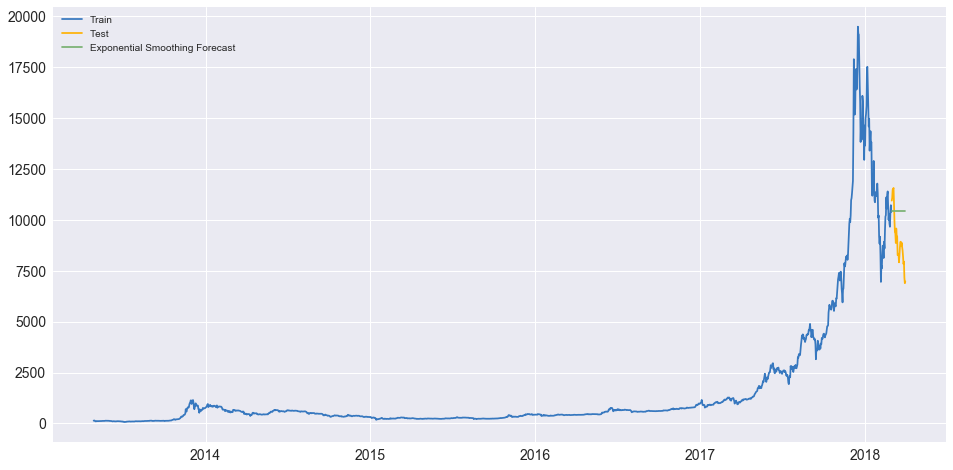

In [44]:
# SimpleExpSmoothing
exp_smooth_fit = SimpleExpSmoothing(np.asarray(btc_train_df['Close'])).fit(smoothing_level=0.5,optimized=False)
btc_test_df['exp_smooth_yhat'] = exp_smooth_fit.forecast(len(btc_test_df))

plt.plot(btc_train_df['Close'], label='Train')
plt.plot(btc_test_df['Close'], label='Test')
plt.plot(btc_test_df['exp_smooth_yhat'], label='Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.show()

In [45]:
rmse = sqrt(mean_squared_error(btc_test_df.Close, btc_test_df.exp_smooth_yhat))
print('RMSE: %.2f' % rmse)

RMSE: 1894.15


## Holt's Method
Holt extended simple exponential smoothing to allow forecasting of data with a trend. It princple it is exponential smoothing applied to both level (the average value in the series) and trend.

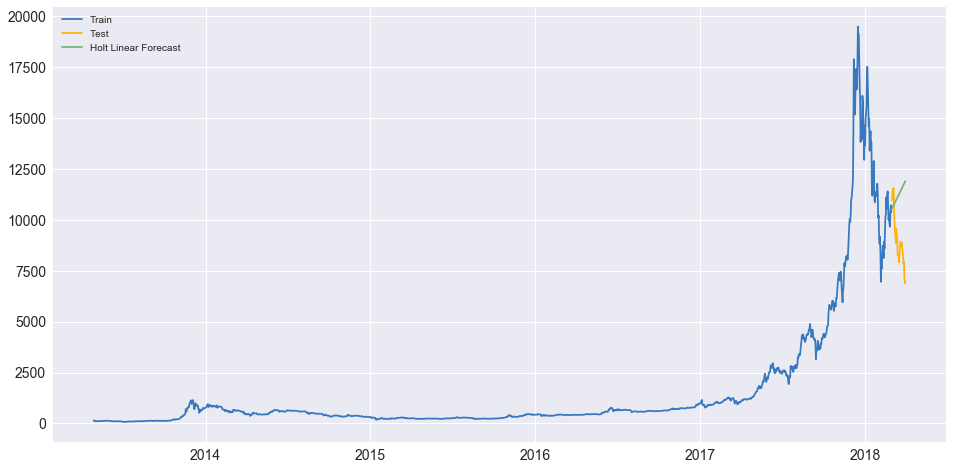

In [46]:
# Holt
holt_linear = Holt(np.asarray(btc_train_df['Close'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
btc_test_df['holt_linear_yhat'] = holt_linear.forecast(len(btc_test_df))

plt.plot(btc_train_df['Close'], label='Train')
plt.plot(btc_test_df['Close'], label='Test')
plt.plot(btc_test_df['holt_linear_yhat'], label='Holt Linear Forecast')
plt.legend(loc='best')
plt.show()

In [47]:
rmse = sqrt(mean_squared_error(btc_test_df.Close, btc_test_df.holt_linear_yhat))
print('RMSE: %.2f' % rmse)

RMSE: 2734.95


## Stationarity check and Seasonal decomposition

If a timeseries is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

The statsmodels library provides a seasonal_decompose method, an implementation of the naive decomposition method, which we will use to examine our timeseries. We chose an additive method (instead of multiplicative), so 'Trend' + 'Seasonal' + 'Residual' results in the 'Observed'.

Dickey–Fuller test: p=0.244952


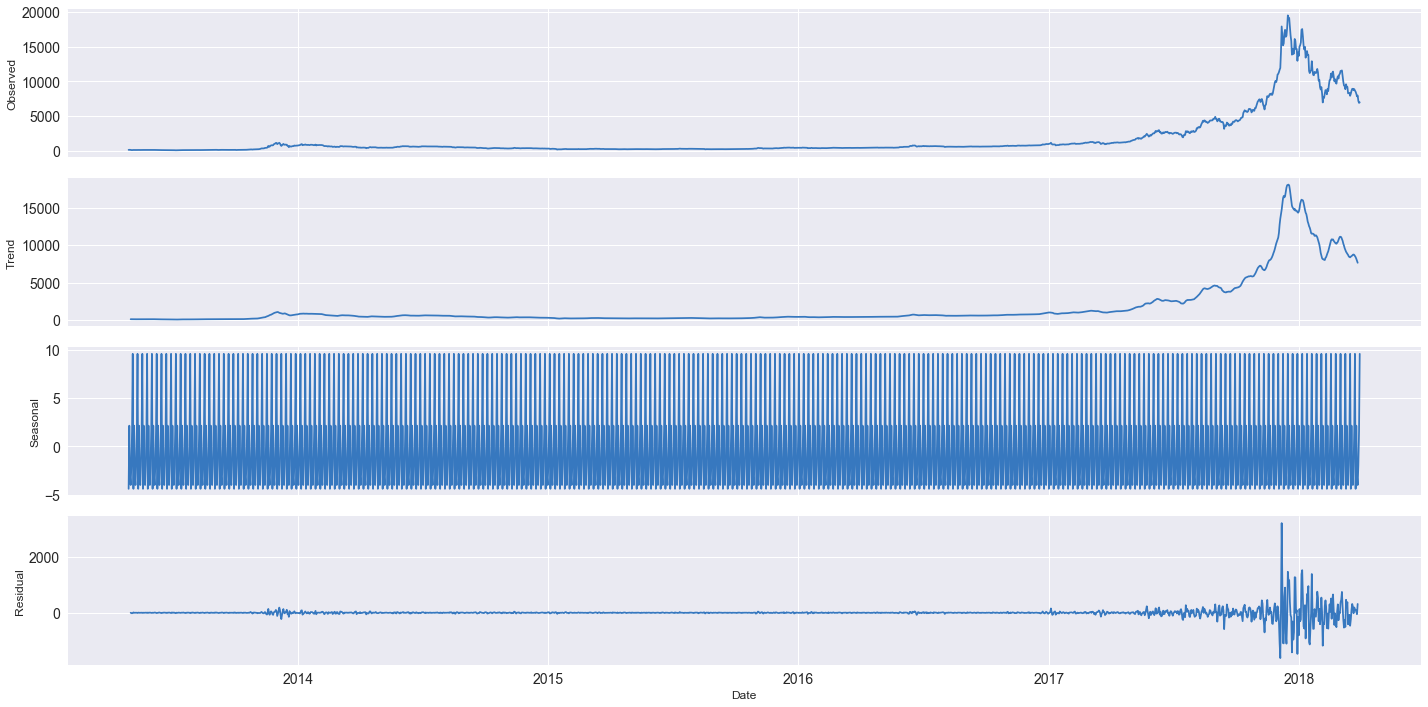

In [64]:
seasonal_decompose(btc_df.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_df.Close)[1])
plt.show()

Lets also try this with monthly resampling.

Dickey–Fuller test: p=0.998616


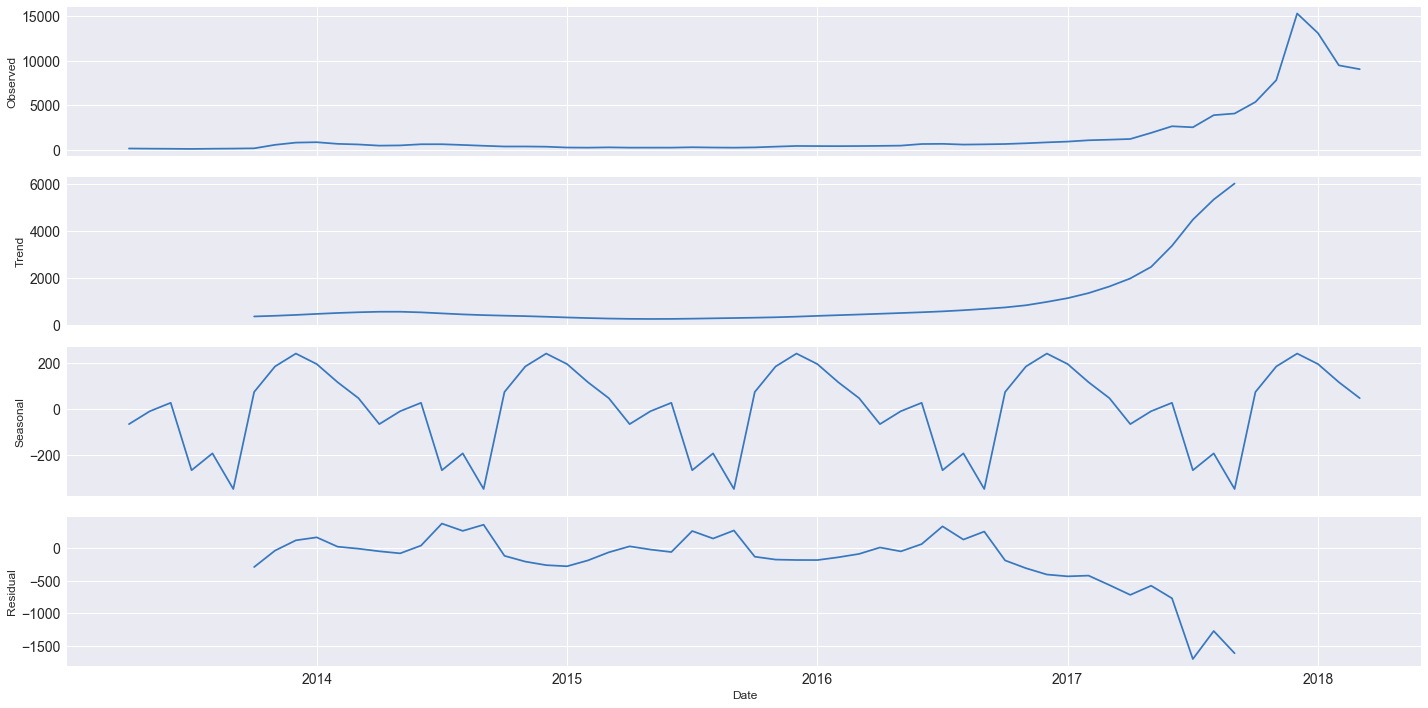

In [65]:
# Resampling to monthly frequency
btc_month_df = btc_df.resample('M').mean()
seasonal_decompose(btc_month_df.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month_df.Close)[1])
plt.show()

The most interesting is the seasonal component which was extracted, which looks like it repeats itself on a yearly basis. 

We can also see that the residuals are fairly constant until around the start of 2017, which is going to make forecasting difficult as we are still inside of this time period where the price is moving insanely.

However, lets proceed anyway. Now that we have identified a seasonal component we can try out the Holt-Winters method.

## Holt-Winters Method
The Holt-Winters method (triple exponential smoothing) is one of the many algorithms that can be used to forecast data points in a series, provided that the series is seasonal (i.e. repetitive over some period). The idea is to apply exponential smoothing to the seasonal components in addition to level and trend.

In this method also, we can implement both additive and multiplicative technique.  The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.

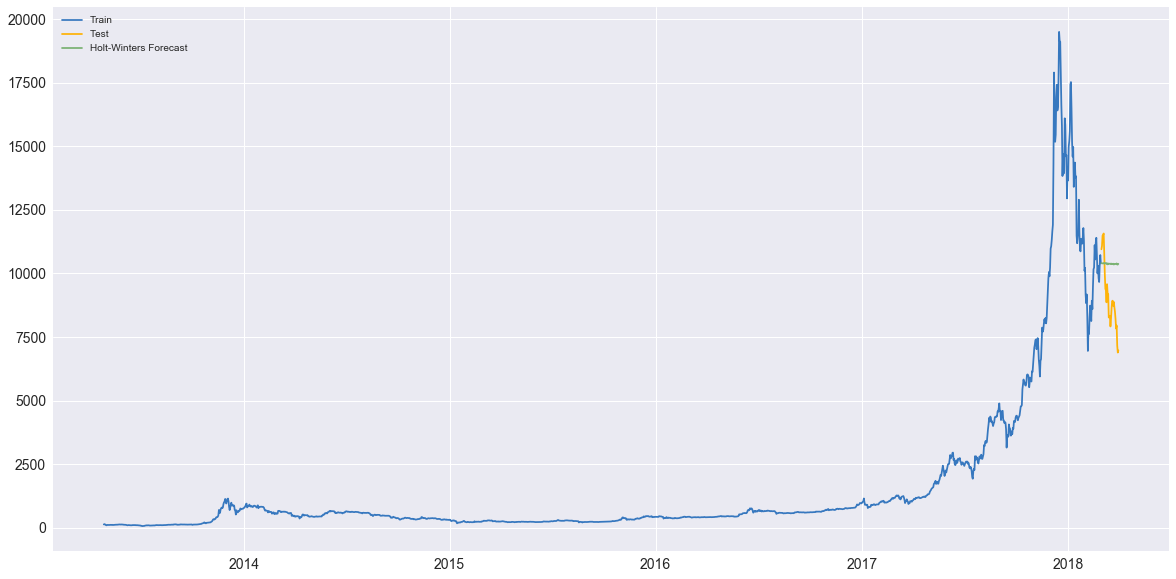

In [59]:
# Holt-Winters
holt_winters = ExponentialSmoothing(np.asarray(btc_train_df['Close']) ,seasonal_periods=120 ,trend='add', seasonal='add',).fit()
btc_test_df['holt_winters_yhat'] = holt_winters.forecast(len(btc_test_df))

plt.plot(btc_train_df['Close'], label='Train')
plt.plot(btc_test_df['Close'], label='Test')
plt.plot(btc_test_df['holt_winters_yhat'], label='Holt-Winters Forecast')
plt.legend(loc='best')
plt.show()

In [60]:
rmse = sqrt(mean_squared_error(btc_test_df.Close, btc_test_df.holt_winters_yhat))
print('RMSE: %.2f' % rmse)

RMSE: 1847.77


## SARIMA

In [71]:
# SARIMA
# ValueError: non-invertible starting seasonal moving average parameters found with `enforce_invertibility` set to True.
'''
sarima = sm.tsa.statespace.SARIMAX(btc_train_df.Close, order=(2, 1, 4),seasonal_order=(0,1,1,365)).fit()
btc_test_df['sarima'] = sarima.predict(start="2013-04-28", end="2018-03-31", dynamic=True)

plt.plot(btc_train_df['Close'], label='Train')
plt.plot(btc_test_df['Close'], label='Test')
plt.plot(btc_test_df['sarima'], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()
'''

ValueError: non-invertible starting seasonal moving average parameters found with `enforce_invertibility` set to True.